# TP 4 et 5 : Classification en utilisant les coefficients de Scattering d'ordres 0, 1 et 2

Auteurs : S. Zhang, L. Mousset & P. Richard (pablo.richard@ens.fr)

Ce notebook couvre les séances de TP 4 et 5. Il est réalisable sur CPU mais sera plus rapide sur GPU.

Comment utiliser des GPU : https://www.kymat.io/gallery_2d/cifar_torch.html#sphx-glr-gallery-2d-cifar-torch-py

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

import sklearn
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score
from kymatio.torch import Scattering2D

from utils import load_obj, colorize, convert_cls2fls  # Librairie maison

# Chargement des données

Dans ce TP, nous allons utiliser les mêmes données qu'aux TP 1 et 2. Normalement, elles ont été sauvées sous un format pickle (.pkl) dans le dossier contenant ce Notebook. Pour les charger, il suffit de faire :

In [2]:
### Paramètres
NbClasses = 9  # Nombre de classes
SizeMaps = 256  # Taille des cartes 256x256 pixels
NbMapsTrain = 20 # Nombre de cartes par classe dans le jeu d'apprentissage
NbMapsTest = 15  # Nombre de cartes par classe dans le jeu de test

### Chargement des données
ImgsTrain = load_obj('ImgsTrain')
ImgsTest = load_obj('ImgsTest')

### Paramètres pour les Scatterings
J = 5  # Nombre d'échelles
L = 8  # Nombre d'orientations

### On vérifie si on a accès à des GPUs
use_cuda = torch.cuda.is_available()  # True or False
print('GPU:', use_cuda)

GPU: True


Dans ce TP, nous allons avoir besoin de la fonction `classify_by_LDA()` codée au TP 1. Vous pouvez la recopier dans la cellule suivante. 

In [3]:
def classify_by_LDA(dataTrain: dict, dataTest: dict) -> dict:
    """
    Classification par LDA.
    :param dataTrain : dataset contenant les données Train
    :param dataTest : dataset contenant les données Test 
    """
    # Construit les features et les labels des données Train et Test pour l'apprentissage supervisé via la fonction convert_cls2fls de utils.py().
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)
    
    # %%%%% TODO %%%%%
    clf = LinearDiscriminantAnalysis() #Instancier l'objet LDA
    clf.fit(featuresTrain, labelsTrain) #fit sur les données Train 
    labels_pred_train = clf.predict(featuresTrain) #Prediction des labels sur les données train
    cmatTrain = confusion_matrix(labelsTrain, labels_pred_train)# Matrice de confusion
    accuracyTrain = accuracy_score(labelsTrain, labels_pred_train)#Calcul de l'accuracy 
    labels_pred_test = clf.predict(featuresTest)#Prédiction des labels sur les données test train
    cmatTest = confusion_matrix(labelsTest, labels_pred_test)# Matrice de confusion
    accuracyTest = accuracy_score(labelsTest, labels_pred_test)#Calcul de l'accuracy sur les données test
    
    # %%%%% end TODO %%%%% 
    
    return {'train_cm': cmatTrain, 'train_acc': accuracyTrain, 'test_cm': cmatTest, 'test_acc': accuracyTest, 'lda': clf}

# Invariance par translation

## 1. Calcul des coefficients de Scattering de 1er ordre

Nous allons utiliser la fonction `Scattering2D()` de la librairie Kymatio. Voir la doc https://www.kymat.io/codereference.html pour la définition des coefficients calculés. 

On définit la fonction suivante pour se restreindre aux coefficients d'ordres 0 et 1:

In [4]:
scattering1 = Scattering2D(shape=(SizeMaps, SizeMaps), J=J, L=L, max_order=1)
if use_cuda:
    scattering1 = scattering1.cuda()  # On passe la fonction sur GPU

**1.1 TODO :** Compléter la fonction suivante qui calcule les coefficients de scattering d'ordre 1 sur un jeu d'images. Il faudra penser à convertir l'image numpy array en Tenseur torch en utilisant la fonction `torch.from_numpy()`. Afin de tenir compte de l'invariance par translation sur l'image, on moyennera les coefficients sur les blocs de pixels. Appliquer cette fonction aux images d'entraînement et de validation. 

In [5]:
def compute_features_o1(Imgs: dict, NbClasses: int, NbMaps: int) -> dict:
    scato1_cls = {}  
    num_features = 1 + (J * L)  
    for i in range(NbClasses): 
        scato1 = np.zeros((NbMaps, num_features))
        for j in range(NbMaps):  
            img = torch.from_numpy(Imgs[i][j]).float().cuda()
            
            scattering_coeffs = scattering1(img)
            
            scattering_coeffs_mean = scattering_coeffs.mean(dim=(-1, -2)).cpu().numpy()
            
            scato1[j, :] = scattering_coeffs_mean
        scato1_cls[i] = scato1
    return scato1_cls

In [6]:
# %%%%% TODO %%%%%
# Applique la fonction sur les données d'entraînement et de test
scato1Train = compute_features_o1(ImgsTrain, NbClasses, NbMapsTrain)
scato1Test = compute_features_o1(ImgsTest, NbClasses, NbMapsTest)
# %%%%% end TODO %%%%%

**1.2 TODO :** Tracer les coefficients obtenus. On utilisera l'échelle log. Comparer les coefficients entres classes et entre les images d'une même classe. Pourquoi a t'on cette structure en marches d'escalier ?  

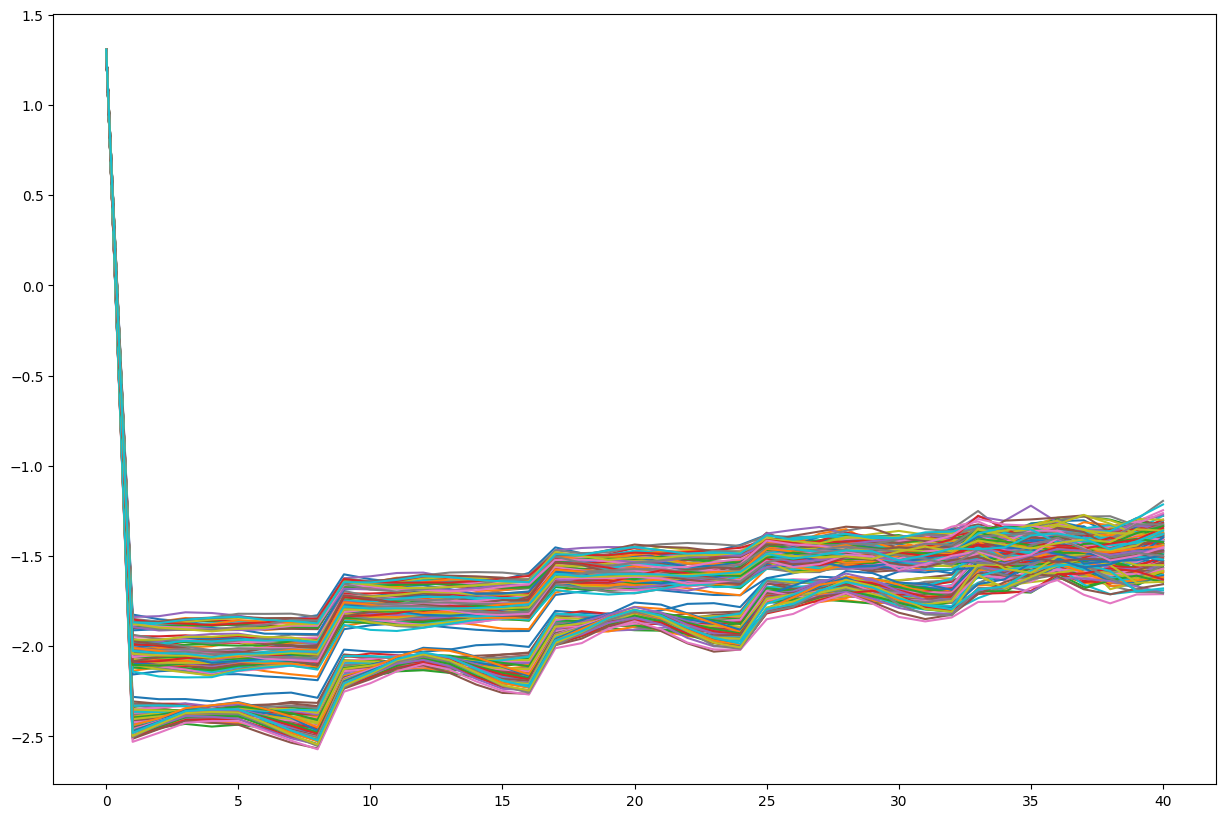

In [7]:
# %%%%% TODO %%%%%
plt.figure(figsize=(15, 10))
for i in range(NbClasses):
    for j in range(NbMapsTrain):
        coeffs = scato1Train[i][j]
        plt.plot(np.log10(coeffs), label=f'Classe {i} - Image {j}')
plt.show()
# %%%%% end TODO %%%%%

**1.3 TODO :** Réaliser une classification par LDA à partir de ces coefficients. Afficher les matrices de confusion et le résultat du test de précision.

Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset train :  0.9722222222222222
Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset test :  0.7111111111111111


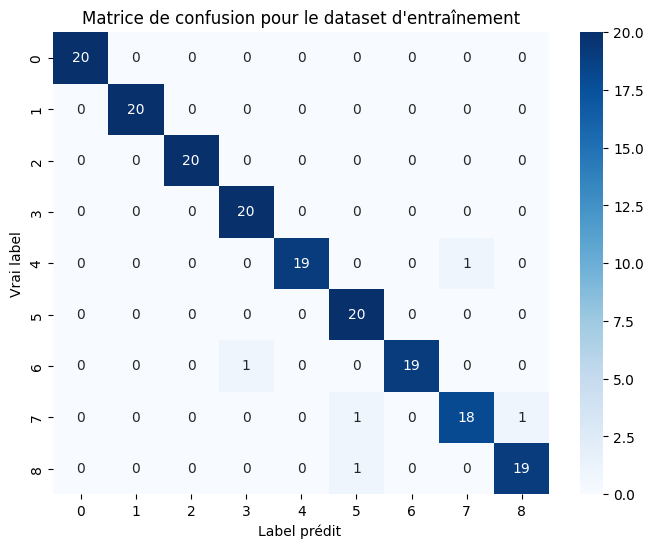

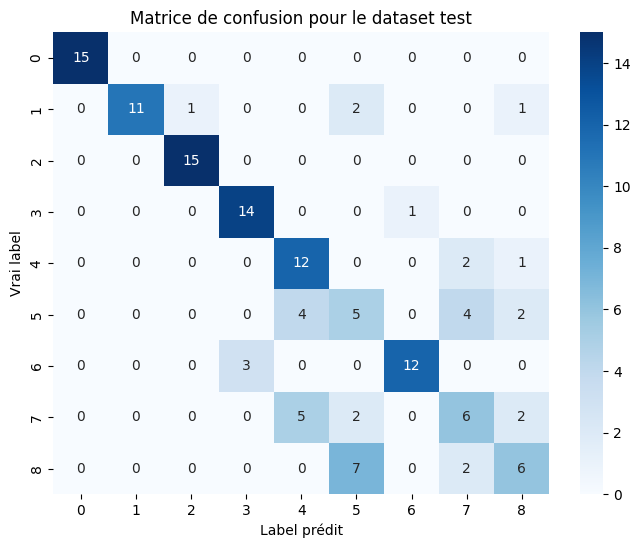

In [8]:
### LDA classification
# %%%%% TODO %%%%%
resultso1 = classify_by_LDA(scato1Train, scato1Test)
# %%%%% TODO %%%%%
import seaborn as sns
# Print les résultats
print("Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset train : ", resultso1["train_acc"])
print("Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset test : ", resultso1["test_acc"])
confusion_matrix_train = resultso1["train_cm"]
confusion_matrix_test = resultso1["test_cm"]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Label prédit ')
plt.ylabel('Vrai label')
plt.title("Matrice de confusion pour le dataset d'entraînement")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion pour le dataset test')
plt.show()
# %%%%% end TODO %%%%% 
### Plot results


# %%%%% end TODO %%%%%

# 2. Calcul des coefficients de scattering de 2nd ordre

On définit la fonction suivante pour inclure les ordres 0, 1 et 2:

In [9]:
scattering2 = Scattering2D(shape=(SizeMaps, SizeMaps), J=J, L=L, max_order=2)
if use_cuda:
    scattering2 = scattering2.cuda()  # On passe la fonction sur GPU

**2.1 TODO :** Comme à la partie précédente, compléter la fonction suivante qui calcule les coefficients de scattering d'ordre 0, 1 et 2. Appliquer la fonction aux données d'entraînement et de test.

In [10]:
def compute_features_o2(Imgs: dict, NbClasses: int, NbMaps: int) -> dict:
    scato2_cls = {}
    num_features = 1 + J*L + (J*(J-1)*L*L//2)  # Number of coefficients (orders 0, 1, 2)
    
    for i in range(NbClasses):  # Boucle sur les classes
        scato2 = np.zeros((NbMaps, num_features))
        for j in range(NbMaps):  # Boucles sur les images
            # %%%%% TODO %%%%%
            img = torch.from_numpy(Imgs[i][j]).float().cuda()
            
            scattering_coeffs = scattering2(img)
            
            scattering_coeffs_mean = scattering_coeffs.mean(dim=(-1, -2)).cpu().numpy()
            
            scato2[j, :] = scattering_coeffs_mean
            # %%%%% end TODO %%%%%
            
        scato2_cls[i] = scato2
        
    return scato2_cls

In [11]:
# %%%%% TODO %%%%%
scato2Train = compute_features_o2(ImgsTrain, NbClasses, NbMapsTrain)
scato2Test = compute_features_o2(ImgsTest, NbClasses, NbMapsTest)
# %%%%% end TODO %%%%%

**2.2 TODO :** Tracer les coefficients obtenus

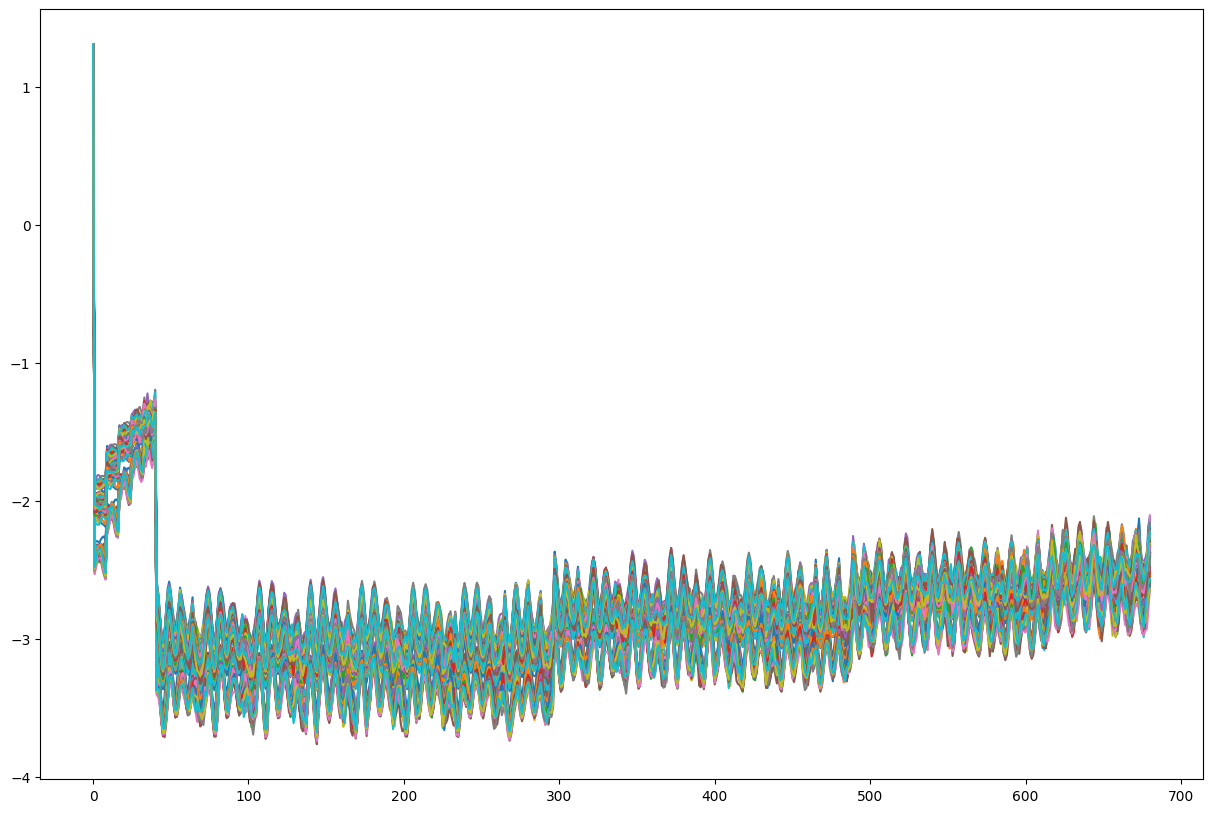

In [12]:
# %%%%% TODO %%%%%
### Plot
plt.figure(figsize=(15, 10))
for i in range(NbClasses):
    for j in range(NbMapsTrain):
        coeffs = scato2Train[i][j]
        plt.plot(np.log10(coeffs), label=f'Classe {i} - Image {j}')
plt.show()
# %%%%% end TODO %%%%%

**2.3 TODO :** Réaliser une classification par LDA

Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset train :  0.9944444444444445
Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset test :  0.6666666666666666


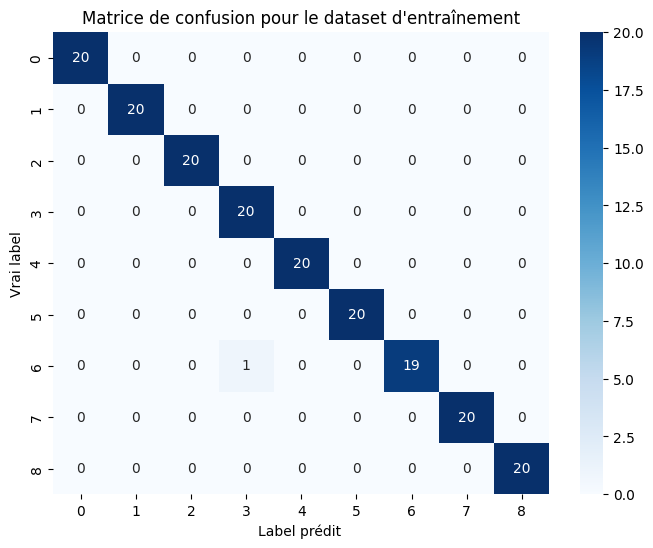

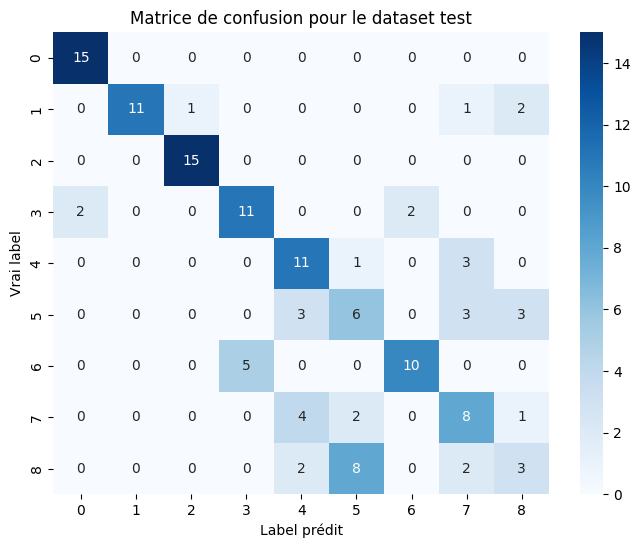

In [13]:
### LDA classification
# %%%%% TODO %%%%%
import seaborn as sns
# Print les résultats
resultso2 = classify_by_LDA(scato2Train, scato2Test)
print("Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset train : ", resultso2["train_acc"])
print("Accuracy de la LDA par calcul de la moyenne sur chaque image pour le dataset test : ", resultso2["test_acc"])
confusion_matrix_train = resultso2["train_cm"]
confusion_matrix_test = resultso2["test_cm"]

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Label prédit ')
plt.ylabel('Vrai label')
plt.title("Matrice de confusion pour le dataset d'entraînement")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Label prédit')
plt.ylabel('Vrai label')
plt.title('Matrice de confusion pour le dataset test')
plt.show()
### Plot results

# %%%%% end TODO %%%%%

**2.4 OPTIONAL :** En plus de la LDA, nous allons utiliser la méthode de classification par **Support Vector Machines (SVM)**. Compléter la fonction suivante qui réalise une classification par SVM. La fonction sera très similaire à la fonction `classify_by_LDA`. On utilisera un noyau linéaire. On pourra s'aider de cette page: https://scikit-learn.org/stable/modules/svm.html

In [14]:
def classify_by_SVM(dataTrain: dict, dataTest: dict, kernel: str='linear', C: float=1) -> dict:
    # Construit les features et les labels des données Train et Test pour l'apprentissage supervisé.
    featuresTrain, labelsTrain = convert_cls2fls(dataTrain, NbClasses, NbMapsTrain)
    featuresTest, labelsTest = convert_cls2fls(dataTest, NbClasses, NbMapsTest)
    
    # %%%%% TODO %%%%%
   
    # %%%%% end TODO %%%%%
    
    return {'train_cm': cmatTrain, 'train_acc': accuracyTrain, 'test_cm': cmatTest, 'test_acc': accuracyTest, 'lda': clf}

**2.5 OPTIONAL :** Réaliser une classification par SVM sur les coefficients de scattering d'ordre 0, 1 et 2. Evaluer les performances de la classification SVM en fonction du paramètre de régularisation C. On tracera le test de précision sur les donnée d'entrainement et de test en fonction de C.

In [15]:
listC = [1, 10, 100, 1000, 10000, 1e5, 1e6]
trainaccC = []
testaccC = []

# %%%%% TODO %%%%%

# %%%%% end TODO %%%%%

# Invariance par rotation

# 3. Calcul des coefficients de 1er ordre invariants par rotation

Comme on l'a vu dans la partie 1, les coefficients semblent invariants par rotation. Ils ne dépendent pas (ou peu) de l'angle. On va donc moyenner sur les angles.

Comme précédemment on utilise la fonction Scattering2D en se restreignant aux ordres 0 et 1. Cette fois, on récupère l'output sous la forme d'une liste de dictionnaires pour pouvoir identifier chaque terme (j, theta).

In [63]:
scattering1 = Scattering2D(shape=(SizeMaps, SizeMaps), J=J, L=L, max_order=1, out_type='list')
if use_cuda:
    scattering1 = scattering1.cuda()  # On passe sur GPU

**3.1 TODO :** Compléter la fonction suivante. Elle devra calculer les coefficients d'ordre 1 et moyenner sur les angles. Appliquer la fonction aux données d'entrainement et de test.

In [ ]:
# Compute order 1 rotational invariance
def compute_features_o1rot(Imgs, NbClasses, NbMaps):
    scato1_cls = {}  
    num_features = 1 + (J * L)  
    for i in range(NbClasses): 
        scato1 = np.zeros((NbMaps, num_features))
        for j in range(NbMaps):  
            img = torch.from_numpy(Imgs[i][j]).float().cuda()
            
            scattering_coeffs = scattering1(img)
            
            scattering_coeffs_mean = scattering_coeffs.mean(dim=(-1, -2)).cpu().numpy()
            
            scato1[j, :] = scattering_coeffs_mean
        scato1_cls[i] = scato1
    return scato1_cls

    scato1rot_cls = {}  # Initialization du dictionnaire
    
    for i in range(NbClasses):  # Boucle sur les classes   
        scato1mat = np.zeros((NbMaps, J, L))  # Initialization de la matrice de coefficients
        
        # %%%%% TODO %%%%%
       
        # %%%%% end TODO %%%%%
                      
        scato1rot_cls[i] = scato1rot # [NbMaps, J]
        
    return scato1rot_cls


In [ ]:
# %%%%% TODO %%%%%
# On applique la fonction aux données d'entrainement et de test
scato1rotTrain = 
scato1rotTest = 
# %%%%% end TODO %%%%%

**3.2 TODO :** Tracer les coefficients obtenus et fonction de l'échelle, pour les différentes classes $i$ et les différentes images $j$.

In [ ]:
# %%%%% TODO %%%%%
### Plot

# %%%%% end TODO %%%%%

**3.3 TODO :** Réaliser une classification par LDA. Afficher les matrices de confusions et les tests d'accuracy obtenus sur les données d'entrainement et de test.

In [ ]:
# %%%%% TODO %%%%%
resultso1rot = 

### Plot results



**3.4 OPTIONAL :** Réaliser une classification par SVM pour différents C. On tracera le test de précision sur les donnée d'entrainement et de test en fonction de C.

In [ ]:
listC = [1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e8]
trainaccC = []
testaccC = []

# %%%%% TODO %%%%%
for C in listC:
    results_svm = 
# %%%%% end TODO %%%%%

# %%%%% TODO %%%%%
# Plot

# %%%%% end TODO %%%%%

# 4. Calcul des coefficients de 2nd ordre invariants par rotation

Nous allons suivre les mêmes étapes que dans la partie précédente mais cette fois ci pour les coefficients d'ordres 1 et 2.

On définit la fonction suivante qui va retourner une liste de dictionnaires.

In [ ]:
scattering2 = Scattering2D(shape = (SizeMaps,SizeMaps), J=J, L=L, max_order=2, out_type='list')
if use_cuda:
    scattering2 = scattering2.cuda()  # Passage sur GPU

**4.1 TODO :** Compléter la fonction suivante. Elle devra calculer les coefficients d'ordre 1 et 2 ou 2 seulement et moyenner sur les angles. Appliquer la fonction aux données d'entrainement et de test.

In [ ]:
def compute_features_o2rot(Imgs, NbClasses, NbMaps, o2only=False):
    
    scato2rot_cls = {}        
    
    for i in range(NbClasses): # Boucle sur les classes            
        scato1nor = np.zeros((NbMaps, J, L))  # Ordre 1
        scato2nor = np.zeros((NbMaps, J, J, L, L)) # Ordre 2
        
        for j in range(NbMaps): # Boucle sur les images
            
            # %%%%% TODO %%%%%
            
            # %%%%% end TODO %%%%%
        
    return scato2rot_cls

In [ ]:
# %%%%% TODO %%%%%
# On applique la fonction aux données d'entrainement et de test
scato2rotTrain = 
scato2rotTest = 
# %%%%% end TODO %%%%%

**4.2 TODO :** Tracer les coefficients obtenus et fonction de l'échelle j, pour les différentes classes $i$ et les différentes images $j$.

In [ ]:
# %%%%% TODO %%%%%
### Plot
# %%%%% end TODO %%%%%

**4.3 TODO :** Réaliser une classification par LDA. Afficher les matrices de confusions et les tests d'accuracy obtenus sur les données d'entrainement et de test.

In [ ]:
# %%%%% TODO %%%%%
resultso2rot = 

### Plot results

# %%%%% end TODO %%%%%

**4.4 OPTIONAL :** Réaliser une classification par SVM pour différents C. On tracera le test de précision sur les donnée d'entrainement et de test en fonction de C.

In [ ]:
listC = [1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e8, 1e9]
trainaccC = []
testaccC = []

# %%%%% TODO %%%%%

for C in listC:
    results_svm = 
# %%%%% end TODO %%%%%

# %%%%% TODO %%%%%
# Plot    

# %%%%% end TODO %%%%%